In [255]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver//")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from scipy import constants

from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian
from potential import gate_potential, linear_problem_instance
from utility import prepare_voltages
from plotting import plot_potential
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

from itertools import product
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

In [2]:
a = 1

In [226]:
# Functions used to create the vertices

def rectangular_gate(center, length, width): 
    """
    Returns vertices of a gate
    """
    x, y = center

    gate = np.array(
        [
            [-width/2, -length/2],
            [-width/2, length/2],
            [width/2, length/2],
            [width/2, -length/2]
        ]
    )
    gate[:, 0] += x
    gate[:, 1] += y

    return gate


def half_disk_gate(R, center=(0, 0), npts=100, shift=0):
    """
    Return vertices of a half disk shaped polygon
    """
    x, y = center

    angles = np.linspace(0, np.pi, npts)

    xs = x + np.cos(angles)*R
    ys = y + np.sin(angles)*R
    
    ys[0] -= shift
    ys[-1] -= shift

    return np.vstack([xs, ys]).T


def ring_gate(R, r, center=(0, 0), npts=100):
    """
    Return vertices of a ring-shaped polygon
    Parameters:
    -----------
        R: outer radius
        r: inner radius
    """
    x, y = center

    angles = np.linspace(0, np.pi, npts)

    Xs = x + np.cos(angles)*R
    Ys = y + np.sin(angles)*R

    xs = x + np.cos(angles)*r
    ys = y + np.sin(angles)*r

    out_ring = np.vstack([Xs, Ys]).T
    in_ring = np.vstack([xs, ys]).T[::-1]

    return np.vstack([out_ring, in_ring])

def covering_ring(center=(0, 0), npts=100):
    """
    Return vertices of a polygon that completes a rectangular region with an internal disk
    """
    angles = np.linspace(0, np.pi/2, npts)
    x, y = center
    Xs = x + np.cos(angles)*(R+gap)
    Ys = y + np.sin(angles)*(R+gap)
    where_cut = np.where(np.abs(Xs - gap - wire_width/2) < 1)[0]
    Xs = Xs[:where_cut[0]]
    Ys = Ys[:where_cut[0]]

    borders = [
        [Xs[-1], R + gap +tunel_length + y],
        [R + 2*gap + 2*wire_width, R + gap +tunel_length + y],
        [R + 2*gap + 2*wire_width, 0],
        [Xs[0], 0]
    ]
    vertex = np.vstack([np.concatenate((Xs, np.array(borders)[:, 0])), np.concatenate((Ys, np.array(borders)[:, 1]))]).T
    return vertex

In [257]:
# Geometry parameters
R = 100
wire_width = 15
r = R-15
gap = 4
tunel_length = 5
y_shift = tunel_length + gap

In [258]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R + 2*gap + 2*wire_width
xmin = -xmax
ymin = 0
ymax = R + gap +tunel_length + y_shift
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]
total_width = 2*xmax
total_length = ymax

In [261]:
y_c = tunel_length/2

ring_plunger = ring_gate(R=R, r=r, center=(0, 0))

tunel_gates = {}
central_tunnel = rectangular_gate(center=(0, R + gap + y_c), length=tunel_length, width=wire_width)

center = (0, max(ring_plunger[:, 1]) - (R-r)/2)
central_ring_tunnel = rectangular_gate(center=center, length=R-r, 
                                      width=wire_width)

In [263]:
xmin = min(ring_plunger[:, 0]) - 10
xmax = -xmin

ymin = min(ring_plunger[:, 1])
ymax = max(central_tunnel[:, 1])

system_vertices = list(product((xmin, xmax), (ymin, ymax)))

system_vertices = np.array(system_vertices)

In [264]:
total_system = system_vertices[np.lexsort((system_vertices[:, 0], system_vertices[:, 1]))][[0, 1, 3, 2]]

In [279]:
ring = Polygon(ring_plunger).difference(Polygon(central_ring_tunnel).buffer(gap))
central_tunnel = Polygon(central_tunnel)
central_ring_tunnel = Polygon(central_ring_tunnel)

In [399]:
accumulation_gates_union = unary_union((ring.buffer(gap),
             central_tunnel.buffer(gap),
             central_ring_tunnel.buffer(gap)))

In [400]:
screening_gate = Polygon(total_system).difference(accumulation_gates_union)

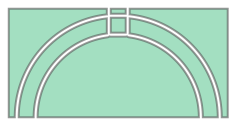

In [401]:
unary_union((screening_gate, unary_union((ring, central_tunnel, central_ring_tunnel))))

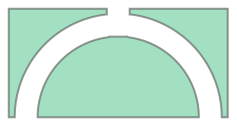

In [402]:
screening_gate

In [409]:
screening_coords = []
for poly in list(screening_gate.geoms):
    screening_coords.append(np.array(list(poly.exterior.coords)))

In [405]:
ring_coords = np.vstack([np.array(list(x.exterior.coords)) for x in list(ring.geoms)])
central_tunnel_coords = np.array(list(central_tunnel.exterior.coords))
central_ring_tunnel_coords = np.array(list(central_ring_tunnel.exterior.coords))

In [407]:
# Set up system paramters
thickness_barrier = 4
thickness_twoDEG = 4
thickness_gates = 6
thickness_self_Al2O3 = 4

meff = 0.023 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG
grid_spacing = grid_spacing_twoDEG

In [411]:
# Solve for Poisson system
layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_barrier,
        permittivity_Al2O3,
        grid_spacing_GaAs,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_barrier

gates_name = ['ring', 'central_tunnel', 'central_ring_tunnel']
gates_vertex = [ring_coords, central_tunnel_coords, central_ring_tunnel_coords]

for i, coord in enumerate(screening_coords):
    gates_name.append('screening' + str(i))
    gates_vertex.append(coord)
    

layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name = gates_name,
                                      gate_objects = gates_vertex,
                                      remove_points = False,
                                      add_to_previous_layer = False,
                                      z_bottom = height,
                                      fix_overlap = True
                                     )
            )

poisson_system = layout.build()


checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


In [412]:
import matplotlib.pyplot as plt

In [413]:
grid_points = poisson_system.grid.points

In [414]:
voltage_regions = poisson_system.regions.voltage.tag_points

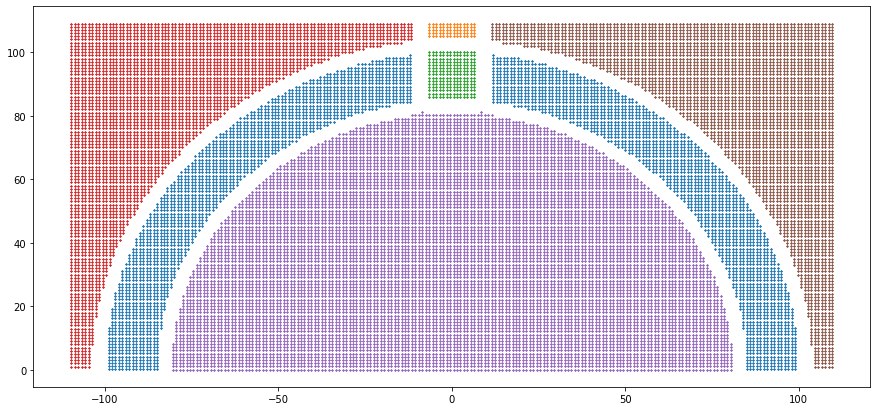

In [416]:
plt.figure(figsize = (15, 7))
for name, indices in voltage_regions.items():
    grid_to_plot = grid_points[indices][:, [0, 1]]
    plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

In [ ]:
linear_problem = linear_problem_instance(poisson_system)